# Neural Networks and Learning Machines

## ANN Exercise 2 - Natural Language Processing (NLP)

Natural Language Processing (NLP) is a set of techniques and algorithms that use computers for analyzing natural human language.  NLP can be used to solve a variety of problems, for example:

* Subject Matter Identification - What are the topics, people, companies or places discussed in this text?
* Sentiment Analysis - Does this text convey a positive, negative or neutral feeling about an entity or subject matter?
* Machine Translation - Convert the input from one language to another, for example, from English to French
* Text-to-Speech - Convert the spoken input into its written form
* Understanding and Interpretation - What information will answer a specific question?

This exercise will teach you the basics of NLP using neural networks, focusing on text classification.
First you will learn a few common ways to encode/embed text as vectors/matrices such that a neural network can use it as an input.
Then you'll use those embeddings in order to embed a dataset of texts and classify them.
Finally you'll learn how to use some more advanced neural networks models in order to generate text.

Before you get started you'll also need to download the file 'wiki.simple.vec' from Canvas, which contains word embeddings that will be used in this exercise. Do **NOT** include 'wiki.simple.vec' in your submission of this exercise.

### Literature

The following sections in the [course book](https://www.deeplearningbook.org/) are relevant for this exercise.
* 12.4 - Natural Language Processing
   - (more subsection details as far from every subsection of NLP is useful to the course)

Optional reading for more details on RNNs:
* 10 - Sequence Modeling: Recurrentand Recursive Nets

In [2]:
!pip install --upgrade torchtext

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchtext.datasets import AG_NEWS
import torchtext
import matplotlib.pyplot as plt
import numpy as np
import random
import gensim

     |████████████████████████████████| 6.9MB 4.8MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


## Turning sentences into matrices

As you know a neural network can only process numbers, so anything we want to process with a neural networks needs to be encoded (embedded) into number, aka vectors.
We've technically already done this for images in exercise 0 and ANN1 where we encoded the images of handwritten digits as numbers representing the grayscale value of each pixel.
For images this process was intuitive as we're already used to representing pixels as numbers, but how do you do this for text?<img src="attachment:image.png" width="600">

There are many different ways to encode text for neural network applications. You can replace each letter by their position in the alphabet, you can replace each word by their position in some dictionary, you can create complex vectors that distribute words in some N-dimensional space, etc, etc.
Most encodings of text is done on the word level, since we know that we want to use words anyways and learning to create words from letters turns out to be quite challenging ('runes' and 'nurse' contain the exact same letters but mean very different things).

In this exercise we will learn to create and use two types of embeddings:
* Bag of Words (BoW)
* Word2Vec (Skip-gram)

We will also learn about another Word2Vec implementation called Continuous Bag of Words (CBoW), and you may implement this as well as an optional task.
 
Finally we will also learn to use pretrained embeddings, where you simply use embeddings created by someone else.

Before we can start with each embedding, we have to discuss the so-called preprocessing pipeline.
The preprocessing pipeline is simply all the step we take from raw data (text) to the input of our neural networks.
There are many ways to form such a pipeline, with many different optional steps to add on, but generally it consists of some or all of the following parts:
* Cleaning - Removing unnecessary/unimportant parts of the text (like making all letters lowercase, removing special characters, etc)
   - Example: "Does Michael like 99 cats?" $\rightarrow$ "does michael like 99 cats"
* Tokenization - Splitting the text into its constituent parts (like words, letters, and/or symbols depending on what embedding you use)
   - Example: "does michael like 99 cats" $\rightarrow$ \["does", "michael", "like", "99", "cats"\]
* Stemming/lemmatization - Switch all words into their baseform (like removing plural, changing verbs to their root form, etc)
   - Example: \["does*", "michael", "like", "99", "cats"\] $\rightarrow$ \["do", "michael", "like", "99", "cat"\]
* Replace rare/special tokens - Switch some rare (only shows up once or twice in the dataset) or special (names, numbers, etc) tokens for tags
   - Example: \["do", "michael", "like", "99", "cat"\] $\rightarrow$ \["do", "\<NAME\>", "like", "\<NUMBER\>", "cat"\]
* Indexing - Create a token to number mapping and replace each token by its number
   - Example: \["do", "\<NAME\>", "like", "\<NUMBER\>", "cat"\] $\rightarrow$ \[454, 3, 872, 2, 234\]
* Embedding - Use an embedder to get a vector to use as input to the machine learning model.

This might seem overwhelming but there are a lot of toolkits that will help you with these steps.
This might also seem like we're getting rid of a lot of useful data, and that's true but often having well-formatted data is better than having more data.
In the end it depends from problem to problem which preprocessing steps are best.
For this exercise you will only need to think of tokenizing, indexing, and embedding.
The AG News dataset have already been tokenized and indexed, but you will need to create a tokeizer and indexer for the "cat on the mat" dataset.

### Datasets

In this exercise we will use two text datasets the "cat on the mat"-dataset and the [AG News dataset](https://www.kaggle.com/amananandrai/ag-news-classification-dataset). The code for creating/downloading both datasets are provided below. The former dataset is a small dummy dataset we will use to visulize and understand the methods. AG News is a large dataset of excerpts from news articles from a few different topics that can be used to train, for example, a news classifier.

#### "Cat on the mat"-dataset

In [3]:
import itertools

animals = ['cat','dog','goat','elephant','eagle','zebra','rhino', 'hippo']
actions = ['sat','stood','jumped','slept']
furniture = ['mat','rug','sofa','bed']

# Generate all combinations of animal, action and furniture
animal_corpus = [f'the {x[0]} {x[1]} on the {x[2]}' for x in itertools.product(animals, actions, furniture)]
vocabulary_size = len(animals) + len(actions) + len(furniture) + 2

print(f'There are {len(animal_corpus)} sentences in the corpus, with a vocabulary of {vocabulary_size} words')
print(f'The first sentence in the corpus is "{animal_corpus[0]}"')


There are 128 sentences in the corpus, with a vocabulary of 18 words
The first sentence in the corpus is "the cat sat on the mat"


In [4]:
# Returns all possible combinations of the argument
[i for i in itertools.product([1],[2,3,4])]

[(1, 2), (1, 3), (1, 4)]

#### AG News dataset

In [5]:
## Download,tokenize, and index the AG News dataset
# This is done in a separate cell as indexing takes some time

ag_train, ag_test = AG_NEWS(ngrams=1, vocab=None)

ag_news_csv.tar.gz: 11.8MB [00:00, 25.3MB/s]
120000lines [00:05, 23487.61lines/s]
120000lines [00:11, 10561.95lines/s]
7600lines [00:00, 10756.24lines/s]


In [6]:
# Our labels are numbers, here's what type of article they represent
ag_labels = {
    0 : 'World',
    1 : 'Sports',
    2 : 'Business',
    3 : 'Sci/Tec'
}

# vocab is a class that will give us the index for any given word/token (vocab['hi'] = <some number>)
vocab = ag_train.get_vocab()

# nr2word is a list that contains the actual tokens for a given index (nr2word[5678] = <some word/token>)
nr2word = vocab.itos

# Let's make a function that takes an entire tensor and returns the string version of that tensor
def tensor2text(tensor):
    return ' '.join([nr2word[index] for index in tensor])

# And a function to turn text into the indexed version (though it won't work with special characters)
def text2tensor(text):
    tensor = torch.Tensor([vocab[token] for token in text.split(' ')])
    return tensor.int()

# And let's see what the dataset actually contains
ag_train_len = len(ag_train) #Get the number of entries in the AG_NEWS dataset

print(
    f'ag_train contains {len(ag_train)} labelled text snippets '
    f'and has a vocabulary size of {len(vocab)}\n'
    f'On index 0, ag_train contains:\n{ag_train[0]}\n'
    f'which has the label {ag_train[0][0]} that translates into "{ag_labels[ag_train[0][0]]}" '
    f'and the text snippet itself translates into:\n{tensor2text(ag_train[0][1])}'
)

ag_train contains 120000 labelled text snippets and has a vocabulary size of 95812
On index 0, ag_train contains:
(2, tensor([  432,   426,     2,  1606, 14839,   114,    67,     3,   849,    14,
           28,    15,    28,    16, 50726,     4,   432,   375,    17,    10,
        67508,     7, 52259,     4,    43,  4010,   784,   326,     2]))
which has the label 2 that translates into "Business" and the text snippet itself translates into:
wall st . bears claw back into the black ( reuters ) reuters - short-sellers , wall street ' s dwindling\band of ultra-cynics , are seeing green again .


## Tokenizing and Indexing
This new corpus of texts needs to be tokenized and indexed before we can start using it.
The tokenizer only needs to be able to handle this simple dataset, so it can be fairly simple.

**Exercise:** Write a tokenizer and an vocabulary class with a function that will give you the index of a token, and a function that will give you the token at a certain index.


In [7]:
def simple_tokenizer(text):
    '''Tokenizes a given string'''
    return text.split(' ')

class SimpleVocabulary():
    def __init__(self, corpus):
        # concatenate all sentences into one, if there are any
        if isinstance(corpus, list):
            corpus = ' '.join(corpus)

        # Give an index to each unique word, kill duplicates
        words =  enumerate(list(set(simple_tokenizer(corpus))))

        # Build a dict containing unique words with indices
        self.token2index = {key.lower(): val for (val, key) in words}
        self.index2token = list(set(simple_tokenizer(corpus)))

    def get_index(self, token):
        return self.token2index[str(token).lower()]
    
    def get_token(self, index):
        return self.index2token[int(index)]

    def __len__(self):
        return len(self.token2index)


def index_sequence(sequence, vocabulary):
    if isinstance(sequence, str):
        sequence = simple_tokenizer(sequence)
    return [vocabulary.get_index(token) for token in sequence]

**Check your solution**: The code cell below will try to tokenize and index a few sentences

In [8]:
animal_vocab = SimpleVocabulary(animal_corpus)
test_sequence = 'the cat stood on the mat'
tokenized_sequence = simple_tokenizer(test_sequence)
print(tokenized_sequence)
indexed_sequence = index_sequence(tokenized_sequence, animal_vocab)
print(indexed_sequence)
assert len(tokenized_sequence) == 6, 'The tokenized sequence should contain all words of the original sequence'
assert len(tokenized_sequence) == len(indexed_sequence), 'The indexed sequence should be as long as the tokenized sequence'
assert indexed_sequence[0] == indexed_sequence[4], 'The index of the same word should be the same'
assert len(animal_vocab) >= 18, 'There should be at least 18 words in the vocabulary (more if you have a out-of-vocabulary token/index)'
print('simple_tokenizer and SimpleVocabulary seems to be properly implemented!')

['the', 'cat', 'stood', 'on', 'the', 'mat']
[2, 10, 14, 16, 2, 6]
simple_tokenizer and SimpleVocabulary seems to be properly implemented!


## Bag of Words (BoW)

Bag of Words is often seen as the default way to embed text as it is very easy to do.
In bag of words each text is represented as a N-dimensional vector, where N is the number of words in the vocabulary.
Each word in the vocabulary is given an index and each text is represented by a vector where the index of each word contains the number of occurences of this word in the text.
For example if we have the vocabulary \["the", "cat", "dog", "sat", "on", "mat", "sofa"\] then the text "the cat sat on the mat" would be represented by the BoW vector \[2, 1, 0, 1, 1, 1, 0\]
Simply put, each text is represented by the by stuffing all of its words into a bag, without care for their order.
While getting rid of the order of words might seem distastrous ("I do like candy" and "do I like candy" doesn't mean the same thing), this simple approach can still be enough to tackle many problems.
<img src="attachment:image.png" width="600">

**Exercise**: Make a BoW embedder that takes the tensor (index vector) representation of a text, the length of the vocabulary, and returns a Bag of Words representation.

In [9]:
def bow_embedder(tensor, vocab_length):

    tensor = tensor.long()
    embedding = torch.zeros(vocab_length)
    unique, counts =  np.unique(tensor, return_counts=True)

    for i, j in zip(unique, counts):
        embedding[i] = j

    return embedding


def bow_embedder_that_does_not_work(tensor, vocab_length):
    ''' HEADS UP: this utterly wrong implementation of the BoW bypasses the
    provided checking snippet '''

    unique, counts = np.unique(tensor, return_counts=True)
    counts = np.append(counts, np.zeros(vocab_length - len(counts)))
    return torch.tensor(counts)

**Check your solution**: The code cell below will try to embed a few sentences using your embedder and will check that the embeddings seem correct.

In [10]:
vocab_length = len(vocab)

sentence_1 = 'the cat dances well for a little while'
sentence_2 = 'for a while the little cat dances well'
sentence_3 = 'the dog sits for a while'
sentence_4 = 'the cat and the dog'

sentence_1_indexed = text2tensor(sentence_1)
sentence_2_indexed = text2tensor(sentence_2)
sentence_3_indexed = text2tensor(sentence_3)
sentence_4_indexed = text2tensor(sentence_4)

sentence_1_bow = bow_embedder(sentence_1_indexed, vocab_length)
sentence_2_bow = bow_embedder(sentence_2_indexed, vocab_length)
sentence_3_bow = bow_embedder(sentence_3_indexed, vocab_length)
sentence_4_bow = bow_embedder(sentence_4_indexed, vocab_length)

# Assert statements are mainly used to test code
# You give them a statement that should be True and they throw an error if it doesn't
assert isinstance(sentence_1_bow, torch.Tensor), 'The BoW embedding should be a tensor'
assert len(sentence_1_bow) == vocab_length, 'The length of the BoW embedding should be the same as the vocabulary'
assert torch.all(sentence_1_bow == sentence_2_bow), 'Texts with the exact same words should have the same BoW embedding'
assert torch.any(sentence_1_bow != sentence_3_bow), 'Texts with different words should have different BoW embeddings'
assert sum(sentence_1_bow) == len(sentence_1_indexed), 'The sum of the BoW embedding should be the number of words in the text'
assert max(sentence_4_bow) == 2, 'A BoW embeddings should count the number of occurances of each word'

print('The bow_embedder seems to be properly implemented!')

The bow_embedder seems to be properly implemented!


#### Visualizing BoW

Before we use our embedder to train an actual neural network on the AG News dataset, let's see what it looks like using our smaller "cat on the mat"-dataset.

In [11]:
## Let's take a sentence and create the BoW representation for it

animal_vocab = SimpleVocabulary(animal_corpus)                                    # Create vocabulary
test_sequence = 'the cat stood on the mat'                                        # Create the sentence
tokenized_sequence = simple_tokenizer(test_sequence)                              # Tokenize the sentence
indexed_sequence = torch.Tensor(index_sequence(tokenized_sequence, animal_vocab)) # Index the sentence and turn it into a tensor
bow_sequence = bow_embedder(indexed_sequence, len(animal_vocab))                  # Create the BoW embedding of the sentence

print(f'The sentence "{test_sequence}" was embedded with the BoW representation: \n{bow_sequence}\n')

The sentence "the cat stood on the mat" was embedded with the BoW representation: 
tensor([0., 0., 2., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.])



### Training a news text classifier

So now that we have a way to embed our sentences, let's use that to train a classifier on the AG News dataset.

**Exercise**: Create a neural network and the train and test loops, and get at least 80% accuracy on the test set. 



In [12]:
# STUFF I WILL ONLY RUN ONCE

vocab = ag_train.get_vocab()

# We create our own dataset to load the BoW embedded texts
class BoWDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, embedder):
        self.dataset = dataset
        self.embedder = embedder
        
    def __getitem__(self, index):
        return self.dataset[index][0], self.embedder(self.dataset[index][1], len(vocab))
  
    def __len__(self):
        return len(self.dataset)


bow_train_data = BoWDataset(ag_train, bow_embedder)
bow_test_data = BoWDataset(ag_test, bow_embedder)
bow_trainloader = DataLoader(bow_train_data, batch_size=1000, shuffle=True)
bow_testloader = DataLoader(bow_test_data, batch_size=1000, shuffle=False)

In [13]:
## CREATE A NEURAL NETWORK TO TRAIN

network = nn.Sequential( 
    nn.Linear(len(vocab), 100),
    nn.ReLU(),
    nn.Linear(100, 4)
    )

optimizer = torch.optim.Adam(network.parameters(), lr = 0.05)
loss_function = nn.CrossEntropyLoss() 

epochs = 1 # The dataset is large so one epoch should do for our purpose (and anything more would take forever)

for epoch in range(epochs):
    for batch_nr, (labels, data) in enumerate(bow_trainloader):
             
        # Make a prediction and compute its loss
        prediction = network(data.float())

        print(prediction)

        print()
        print(labels)
        break


        loss = loss_function(prediction, labels)


        # Upgrade weights
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        print(f'\rEpoch {epoch+1} [{batch_nr+1}/{len(bow_trainloader)}] - Loss: {loss}',
            end='')



tensor([[-0.0835, -0.0943, -0.0006, -0.0203],
        [-0.0757, -0.0976, -0.0014, -0.0219],
        [-0.0733, -0.0948,  0.0031, -0.0194],
        ...,
        [-0.0805, -0.0960, -0.0063, -0.0237],
        [-0.0780, -0.0931,  0.0057, -0.0279],
        [-0.0794, -0.0955, -0.0020, -0.0174]], grad_fn=<AddmmBackward>)

tensor([1, 3, 2, 1, 3, 2, 1, 0, 2, 2, 3, 1, 0, 1, 2, 0, 2, 3, 0, 0, 2, 2, 3, 1,
        3, 1, 3, 3, 2, 2, 0, 3, 2, 2, 3, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 3,
        3, 1, 1, 2, 1, 0, 1, 0, 0, 0, 3, 0, 3, 3, 0, 1, 0, 1, 1, 3, 2, 1, 3, 3,
        0, 1, 3, 2, 2, 0, 0, 3, 0, 1, 3, 1, 0, 0, 0, 0, 2, 2, 0, 3, 0, 1, 0, 1,
        2, 0, 3, 3, 2, 0, 3, 1, 1, 1, 3, 1, 2, 3, 1, 0, 0, 2, 2, 3, 0, 1, 0, 3,
        3, 1, 2, 2, 1, 1, 0, 2, 1, 0, 3, 0, 0, 2, 1, 0, 1, 0, 1, 0, 3, 2, 0, 1,
        0, 1, 1, 0, 1, 2, 3, 2, 2, 0, 3, 0, 3, 1, 2, 3, 1, 1, 0, 1, 2, 3, 1, 3,
        0, 1, 1, 3, 2, 0, 3, 0, 3, 3, 3, 1, 2, 0, 3, 3, 3, 3, 2, 0, 2, 2, 2, 2,
        1, 1, 3, 3, 2, 2, 3, 1, 1, 0, 2, 2, 

In [ ]:
### Test set accuracy

with torch.no_grad():
    matches = 0
    datapoints = 0

    for batch_nr, (labels, data) in enumerate(bow_testloader):
        prediction = network(data.float())
        matches += sum([np.argmax(prediction[i].detach().numpy()) == labels[i] for i in range(len(labels))])
        datapoints += len(labels)
  
    try:
        print(f'The accuracy of the network on test set is {matches/datapoints}.')
    except:
        print('Math error on matches/datapoints.')


        '''
        print(max(labels))
        print([i for i in labels[0:2]])
        print([np.argmax(i) for i in labels[0:2]])
        print([i for i in prediction[0:2]])
        print([np.argmax(i) for i in prediction[0:2]])
        break
        '''

The accuracy of the network on test set is 0.9194737076759338.


In [ ]:
# Let's print a sentence and predict it's category
try:
    sentence_index = 100
    prediction = torch.argmax(network(torch.unsqueeze(bow_embedder(ag_train[sentence_index][1], len(vocab)).float(), dim=0))).item()

    print(
        f'The network predicted that \n"{tensor2text(ag_train[sentence_index][1])}"\n should be in the category {ag_labels[prediction]}'
    )
except:
    print('We did not train the network yet during this session :)')

We did not train the network yet during this session :)


## Word2Vec

As you might already have thought BoW embeddings have a few problems.
Firstly, it diregards the order of words which, as previously stated, can be quite important.
Secondly, the size of the embedding grows larger with the size of the vocabulary.
While the second issue can be solved by limiting the vocabulary to the most common/important words, this remains a fairly large vector with very few non-zero elements (a sparse vector).

One commonly used alternative that fixes both of these issues is the so-called Word2Vec embeddings.
Word2Vec can be summarized as using machine learning to learn non-sparse (most, if not all, entries are non-zero) word embeddings with fewer dimensions (typically between 100 and 1000). A text is then represented as a matrix where the first row (or column depending on how you use it) represents the first word and so on.
<img src="attachment:image.png" width="700">

So how do you learn an embedding?
Again, there are many ways to do this, but the most common Word2Vec methods use the idea that a word is defined by the company it keeps.
That is, an embedding of a word is good if you can either use it to predict which the surrounding words are or if it can be predicted using the surrounding words.
So you either train a model to predict the surrounding words from the central word, or train it to predict a word from the surrounding ones.
These two methods are called Skip-Gram and Continuous Bag of Words (CBoW) respectively and are illustrated by the images below.

<h1><center>Skip-gram</center></h1>| <h2><center>CBoW</center></h2>
- | -
<img src="attachment:image-3.png" width="300"> | <img src="attachment:image-2.png" width="300">

The logic behind these methods can be better understood by imagining synonyms.
If we're creating embeddings (codes) to represent different words, it makes sense that similar words should have similar embeddings.
Since synonymous words would have many similar surrounding words in many sentences, telling the difference between the two would be difficult, and thus giving them similar embeddings would lead to a lesser error.
However, words that have slightly different meaning cannot have the same embeddings, because that would make predicting words from that embedding more difficult.

While training useful such embeddings for every single words takes huge datasets of texts, this only has to be done once and then those embeddings can be used for many different applications.
Due to this time consuming training we will only train a very small sample of word embeddings to learn how it's done and better understand them.
Afterwards we will use pretrained embeddings to do some actual prediction.

With this in mind we will use the "cat on the mat" dataset to train our embeddings.
Our goal is to create embeddings where each group of words (animals, furniture, actions, and other) are given distinct groups in the encoding space.

### Skip-gram embedding

In Skip-gram embeddings we want to predict the surrounding words from a given one.
Rather than for a given word predicting all the surrounding words at once, we'll create context-target pairs.
We decide on a window size, and create a context target pair with the central word being the context and each word in the window of surrounding words will be our target. 
<img src="attachment:image.png" width="600">

The goal of the training is to predict the target word given the context word.
We provide the function for creating context-target pairs below, so you don't need to implement this yourself.

We'll use these context-target pairs to train a neural network to predict the target word and, hopefully, during this training the hidden layer of the neural network will become the embedding of our context word.
So in order to get the embedding after training, we simply input a word and extract the values of the hidden layer of the network

In [14]:
## Hyperparameters for Skip-gram Embedding
WINDOW_SIZE = 2
EMBEDDING_SIZE = 2

In [ ]:
# This is code for the skipgram generation (you don't need to understand it)
def skipgrams(sequences, window_size = 2, shuffle = True):
    couples = []
    for sequence in sequences:
        for i, wi in enumerate(sequence):
    
            window_start = max(0, i - window_size)
            window_end = min(len(sequence), i + window_size + 1)
            for j in range(window_start, window_end):
                if j != i:
                    wj = sequence[j]
                    couples.append([wi, wj])

    if shuffle:
        seed = random.randint(0, 10e6)
        random.shuffle(couples)

    return torch.Tensor(couples)
    

In [ ]:
# We print the path from text to skip-grams so you can see the process

animal_vocab = SimpleVocabulary(animal_corpus)

test_sequence = 'the cat stood on the mat'
print('The sentence:',test_sequence)

tokenized_sequence = simple_tokenizer(test_sequence)
print('The sentence split into tokens:',tokenized_sequence)

indexed_sequence = [animal_vocab.get_index(token) for token in tokenized_sequence]
print('The indexed sentence:', indexed_sequence)

skipgrams_sequence = skipgrams([indexed_sequence], shuffle=False).int()
print('All generated skip-gram pairs:', skipgrams_sequence)

skipgrams_sequence_words = [(animal_vocab.get_token(x[0]), animal_vocab.get_token(x[1])) for x in skipgrams_sequence]
print('The skip-gram pairs as text:', skipgrams_sequence_words)

The sentence: the cat stood on the mat
The sentence split into tokens: ['the', 'cat', 'stood', 'on', 'the', 'mat']
The indexed sentence: [0, 14, 3, 9, 0, 16]
All generated skip-gram pairs: tensor([[ 0, 14],
        [ 0,  3],
        [14,  0],
        [14,  3],
        [14,  9],
        [ 3,  0],
        [ 3, 14],
        [ 3,  9],
        [ 3,  0],
        [ 9, 14],
        [ 9,  3],
        [ 9,  0],
        [ 9, 16],
        [ 0,  3],
        [ 0,  9],
        [ 0, 16],
        [16,  9],
        [16,  0]], dtype=torch.int32)
The skip-gram pairs as text: [('the', 'cat'), ('the', 'stood'), ('cat', 'the'), ('cat', 'stood'), ('cat', 'on'), ('stood', 'the'), ('stood', 'cat'), ('stood', 'on'), ('stood', 'the'), ('on', 'cat'), ('on', 'stood'), ('on', 'the'), ('on', 'mat'), ('the', 'stood'), ('the', 'on'), ('the', 'mat'), ('mat', 'on'), ('mat', 'the')]


In [ ]:
# We create the actual skip-gram pairs for the entire "cat on the mat"-dataset

animal_vocab = SimpleVocabulary(animal_corpus)
indexed_text = [[animal_vocab.get_index(token) for token in simple_tokenizer(text)] for text in animal_corpus]
pairs = skipgrams(indexed_text, WINDOW_SIZE)
print(f'There are {len(pairs)} pairs of skip-grams created from the "cat in the mat" dataset.')

There are 2304 pairs of skip-grams created from the "cat in the mat" dataset.


For creating the skipgram embedding we will not use nn.Sequential as we usually do when creating neural networks.
Instead we will create a subclass of nn.Module to create our own PyTorch module.
This is useful when we need to create neural networks with non-linear structure, or with some quirk that cannot be implemented with existing modules.
In short a nn.Module needs only a single function called 'forward' that takes the input and performs the forward pass of the network using differentiable functions (most torch functions and mathematical operations supports this).
Any part of the module that needs to be initialized (like nn.Linear) needs to be so in the \_\_init\_\_ function of the network after the super().\_\_init\_\_() statement.
In this exercise you will not need to write the \_\_init\_\_ function.
For more information on creating networks as subclasses of nn.Module, read **[here](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#nn-module)**.

**Exercise**: Create the SkipgramEmbedder class, a neural network that first reduces the one-hot embedding of one word to a smaller embedding space and then predicts the one-hot embedding of the paired word using that. These embeddings should then be such that most groups of words are separate on the embedding space (though if two groups overlaps that is fine). Think of why the groups gets embedded the way they do.

In [ ]:
# An Embedding layer used for turning int into one-hot
to_onehot = nn.Embedding.from_pretrained(torch.eye(len(animal_vocab))) 

class SkipgramEmbedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = nn.Linear(len(animal_vocab), EMBEDDING_SIZE)
        self.output_layer = nn.Linear(EMBEDDING_SIZE, len(animal_vocab))
        self.softmax = nn.Softmax(dim=1)
    
    def embed(self, context_index):
        
        # IMPLEMENT THE EMBEDDING STEP OF THE SKIP-GRAM EMBEDDER
        context_onehot = to_onehot(context_index)                               # Make a one-hot representation of the index
        embedding = self.input_layer(context_onehot)                            # Pass the one-hot representation throught the first layer to create an embedding
        return embedding
    
    def forward(self, context_index):
        
        # IMPLEMENT THE FORWARD PASS FOR PREDICTING TARGET WORD FROM THE CONTEXT WORD
        embedding = self.embed(context_index) 
        output = self.output_layer(embedding)                                   # Pass the embedding through the second layer to create an output
        prediction = self.softmax(output)                                       # Pass the output through softmax 
        return prediction


#### Learing the embeddings
Run the code below to train your embedder so it learns the embeddings. Use your previous code for the training process.

In [ ]:
model = SkipgramEmbedder()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.1)
loss_function = nn.CrossEntropyLoss()

#Epochs
TOTAL_EPOCHS = 1000
BATCH_SIZE = 2303

# For each epoch
for epoch in range(TOTAL_EPOCHS):
    
    # A variable for containing the sum of all batch losses for this epoch
    epoch_loss = 0
    
    # Lower index
    start = 0
    
    for batch_nr, end in enumerate(range(BATCH_SIZE, len(pairs), BATCH_SIZE)):
        
        targets = torch.Tensor(pairs[start:end,0]).long()
        contexts = torch.Tensor(pairs[start:end,1]).long()
        
        start = end
        
        # Predict for context word in the batch what the target word should be
        prediction = model.forward(contexts)

        # Calculate the loss of the prediction by comparing to the actual target word
        loss = loss_function(prediction, targets)

        # Backpropogate the loss through the network to find the gradients of all parameters
        loss.backward()

        # Update the parameters along their gradients
        optimizer.step()
       
        # Clear stored gradient values
        optimizer.zero_grad()
        
        # Add the loss to the total epoch loss (item() turns a PyTorch scalar into a normal Python datatype)
        epoch_loss += loss

        #Print the epoch, batch, and loss
        print(
            f'\rEpoch {epoch+1} [{batch_nr+1}/{len(targets)/BATCH_SIZE}] - Loss: {loss}',
            end=''
        )


Epoch 1000 [1/1.0] - Loss: 2.642103910446167

#### Visualizing the embeddings
You don't need to understand the code below, instead we will explain it here.
Below we run each individual word in the "cat on the mat" dataset throgh the SkimgramEmbedder in order to get its embedding. Then we use [Prinipal Component Analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) in order to reduce the embedding dimensionality to 2 (if you have changed the dimensionality to anything larger) and then we print that as a graph where each group of words have been given the same color in order to display how they are grouped. Ideally the training should have converged towards clear groupings of similar words. If it hasn't try running the training again (it shouldn't take that many tries to get an embedding that clearly separates most groups of words). If you cannot get an embedding that separates all groups, don't worry about it so long as most groups are separated.

The embeddings if all words in the vocabulary
[[ 0.92594254 -7.795179  ]
 [ 1.9051583   8.135748  ]
 [ 0.45397973 -0.07449305]
 [ 1.92826     8.187     ]
 [ 0.49560046 -0.07455316]
 [ 1.9303874   8.185715  ]
 [ 0.4541508  -0.07448563]
 [ 0.49562228 -0.07452554]
 [ 0.49556577 -0.07455528]
 [ 2.1424937   9.501736  ]
 [ 0.45409203 -0.07451984]
 [ 0.45399213 -0.07452455]
 [ 0.45394957 -0.074494  ]
 [ 0.45398962 -0.07448977]
 [ 0.45408428 -0.07451016]
 [ 0.45395744 -0.07449472]
 [ 0.49571848 -0.07454461]
 [ 1.9711449   8.036885  ]]


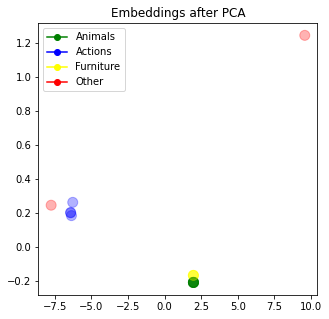

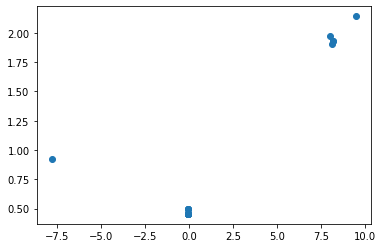

In [ ]:
%matplotlib inline
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


category_colors = {'animals' : 'green', 
                   'actions' : 'blue',
                   'furniture' : 'yellow'}

colors = []
for i in range(vocabulary_size):
    colors.append('red')
    
for word in animal_vocab.index2token:
    index = animal_vocab.get_index(word)
    if word in animals:
        colors[index] = category_colors['animals']
    elif word in actions:
        colors[index] = category_colors['actions']
    elif word in furniture:
        colors[index] = category_colors['furniture']

# Plots embeddings using PCA (you don't need to understand it)
def plot_embeddings_after_pca(vectors):  
        """
        Perform PCA and plot the resulting 2 components on X and Y axis
        Args:
          embedding_weights - the set of vectors to 
        """
        pca = PCA(n_components=2)
        vectors_pca = pca.fit_transform(vectors)
        plt.figure(figsize=(5,5))
        
        # We do not draw the first element, which is the 'Out-of-Vocabulary' token
        plt.scatter(vectors_pca[:,0], vectors_pca[:,1], c=colors, s=100, alpha=0.3);
        plt.title('Embeddings after PCA')
        legend_elements = [
                    plt.Line2D([0], [0], marker='o', color=category_colors['animals'], label='Animals'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['actions'], label='Actions'),
                    plt.Line2D([0], [0], marker='o', color=category_colors['furniture'], label='Furniture'),
                    plt.Line2D([0], [0], marker='o', color='red', label='Other'),
                  ]

        # Create the figure
        plt.legend(handles=legend_elements);

# Extracting the embeddings for every word in the vocabulary, detaching them from PyTorch, and turning them into numpy
numpy_word_vectors = model.embed(torch.Tensor(range(vocabulary_size)).long()).detach().numpy()

print('The embeddings if all words in the vocabulary')
print(numpy_word_vectors)

# Display the most significant axes of the word vectors using PCA
plot_embeddings_after_pca(numpy_word_vectors)


# Check what the 'other' category holds (the words 'on' and 'the')
plt.figure()
plt.scatter(numpy_word_vectors[:,1], numpy_word_vectors[:,0])


In [ ]:
vocab[0]

0

## Bonus task: Using pretrained embeddings USE THE OTHER DOC FOR THIS

A problem with training word embeddings is that you would need to have a dataset containing all words you want to embed in many different sentences.
This adds up to needing really large datasets (the entirety of Wikipedia for example) to create good embeddings.
This is unfeasible for most people as it requires huge amounts of computational power and the ability to download and store huge datasets.
Not to mention that if everyone did this it would waste a lot of energy for everyone to do this.
Instead a lot of embeddings created by people access to large computational resources have been made publicly available.
Since it takes a lot of resources to train an embedding, but barely anything to use them this is an efficient way to get access to good word embeddings.

We will use one such pretrained embedding in order to actually train a network to make predictions on the AG News dataset (coming soon).

In [ ]:
from gensim.models import KeyedVectors

# Load embeddings from the pre-trained file
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [15]:
print(wv['horse'])

NameError: ignored

Word embeddings contain mathematical representations of the underlying meaning of words. As every embedding is in the same dimensions, you can utilize linear algebra to look inside how the model thinks.

Try playing around with a few words and methods to investigate how the model views language.

In [ ]:
#king = wv.most_similar("king")
dist = wv.similarity("king","dog")
#print(king)
print(dist)

0.12812497


There is a famous example of embedding maths that goes "king" - "man" + "woman" = "queen". This example, and embedding maths in general, utilize the fact that embeddings are just vectors in a high dimenionsal vector space, and certain features of language tend to exist along certain axises and cluster together with similar words. We would thus expect king to have a presence in the "royalty"-axis, and in the "man"-axis. Removing man and adding woman should thus result in "royalty" + "woman", in other words a queen. See if you can find any other examples where semantic mathematics work, or an example where it clearly doesn't work. Do the results make sense to you?

In [ ]:
print(wv.similar_by_vector(wv['king']))
print("")
similars = wv.similar_by_vector(wv['king']-wv['man']+wv['woman']-wv['boy']+wv['girl'])
print(similars)

similars[0]

You might be interested in investigating the vocabulary of your model, or the embedding of a specific word

In [ ]:
for i, word in enumerate(wv.vocab):
    if i == 10:
        break
    print(word)
print(wv.get_vector(word))

</s>
in
for
that
is
on
##
The
with
said


array([ 2.60009766e-02, -1.89208984e-03,  1.85546875e-01, -5.17578125e-02,
        5.12695312e-03, -1.09863281e-01, -8.17871094e-03, -8.83789062e-02,
        9.66796875e-02,  4.83398438e-02,  1.10473633e-02, -3.63281250e-01,
        8.20312500e-02, -2.12402344e-02,  1.58203125e-01,  4.41894531e-02,
       -1.17797852e-02,  2.12890625e-01, -5.73730469e-02,  5.66406250e-02,
       -1.07421875e-01,  1.85546875e-01,  7.71484375e-02,  1.44958496e-04,
        1.52343750e-01, -6.54296875e-02, -1.52343750e-01,  2.25585938e-01,
        8.10546875e-02,  8.88671875e-02,  7.32421875e-02, -1.03515625e-01,
       -6.68945312e-02,  1.76757812e-01,  2.12890625e-01,  1.40625000e-01,
       -3.41796875e-02,  1.78222656e-02,  5.95703125e-02,  2.86102295e-04,
        5.88378906e-02,  9.27734375e-03,  1.66992188e-01, -2.70080566e-03,
        1.15722656e-01,  1.04492188e-01,  5.37109375e-02,  1.85546875e-02,
        1.06445312e-01,  5.05371094e-02, -1.64794922e-02, -1.27929688e-01,
        2.16796875e-01,  

In [ ]:
# FUNCTION STORAGE

def to_onehot(list_of_numbers):
    if list_of_numbers.shape == torch.Size([]):
        return torch.tensor([np.eye(4)[list_of_numbers]])
    else:
        generator = (i for i in list_of_numbers)
        return torch.tensor([np.eye(4)[i] for i in generator])


def to_float(tensor):
    generator = (i for i in tensor)
    return torch.tensor([torch.float(i) for i in generator])
